In [0]:
from google.colab import drive
drive.mount("/m5")

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import functools
import time
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
tf.enable_eager_execution()

In [0]:
from tensorflow.keras.layers import Embedding

In [0]:
INPUT_SERIES_SIZE = 60
OUTPUT_SERIES_SIZE = 28

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
UNITS = 1024

In [0]:
sales_df = pd.read_csv("/m5/My Drive/m5-forecasting-accuracy/sales_train_validation.csv")
calendar_df = pd.read_csv("/m5/My Drive/m5-forecasting-accuracy/calendar.csv")
prices_df = pd.read_csv("/m5/My Drive/m5-forecasting-accuracy/sell_prices.csv")

In [0]:
pd.read_csv("/m5/My Drive/m5-forecasting-accuracy/sell_prices.csv")

ERROR! Session/line number was not unique in database. History logging moved to new session 59


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [0]:
pd.read_csv("/m5/My Drive/m5-forecasting-accuracy/")

In [0]:
test_sales_df = sales_df[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'] + ["d_{0}".format(i) for i in range(1826, 1914, 1)]]

In [0]:
 # 2016-04-25 ~ 2016-05-22 是需要prediction的 time
#calendar_df[(calendar_df['int_d'] > 1913) & (calendar_df['int_d'] <= 1913 + 28)]  

In [0]:
#test_df = sales_df.iloc[[23, 1042, 7984]].copy()

In [0]:
class BuildSalesDF:
  def __init__(self, df):
    self.df = df
    self.label_encoder_dict = {}
    self.min_max_scaler = MinMaxScaler()
    self.tot_data_list = []
    self.data_x = []
    self.data_y = []
    self.series_length = self.df.shape[1] - 6

  def buildLabelEncoder(self, target_column):
    le = LabelEncoder()
    le.fit(self.df[target_column])
    self.label_encoder_dict[target_column] = le
    self.df[target_column + '_index'] = le.transform(self.df[target_column])
    self.df = self.df.drop(target_column, axis = 1)

  def build(self):
    for col in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
      self.buildLabelEncoder(col)

    self.df = self.df.melt(id_vars = ['id', 'item_id_index', 'dept_id_index', 'cat_id_index', 'store_id_index', 'state_id_index'])
    self.min_max_scaler.fit(self.df['value'].values.reshape(-1, 1))
    self.df['value'] = self.min_max_scaler.transform(self.df['value'].values.reshape(-1, 1))

    self.df = self.df.rename(columns = {'variable': 'd'})
    self.df['d'] = list(map(lambda x: int(x.replace('d_', '')), self.df['d']))

    groupDF = self.df.groupby('id')
    for x in groupDF.groups:
      self.tot_data_list.append(groupDF.get_group(x).sort_values('d'))

  def transformAllData(self):
      last_t = self.series_length - INPUT_SERIES_SIZE - OUTPUT_SERIES_SIZE + 1

      for idx in tqdm(range(len(self.tot_data_list))):
        for t in range(last_t):
          dd = self.tot_data_list[idx][['item_id_index', 'dept_id_index', 'cat_id_index', 'store_id_index', 'state_id_index', 'value']].to_numpy()
          self.data_x.append(dd[t:(t + INPUT_SERIES_SIZE), :])
          self.data_y.append(dd[(t + INPUT_SERIES_SIZE):(t + INPUT_SERIES_SIZE + OUTPUT_SERIES_SIZE), -1].reshape(OUTPUT_SERIES_SIZE, 1))

  def run(self):
    self.build()
    print("Transform data into list...")
    self.transformAllData()
    self.all_data_x = np.array(self.data_x, dtype = np.float32)
    self.all_data_y = np.array(self.data_y, dtype = np.float32)

In [0]:
sales_df_obj = BuildSalesDF(test_sales_df)
sales_df_obj.run()

In [0]:
train_x, val_x, train_y, val_y = train_test_split(sales_df_obj.all_data_x, sales_df_obj.all_data_y, test_size = 0.2)

In [0]:
STEPS_PER_EPOCH = train_x.shape[0] // BATCH_SIZE

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))

In [0]:
# example_input_batch, example_target_batch = next(iter(train_dataset))

In [0]:
item_id_embedding_layer = Embedding(3049, 10, input_length = BATCH_SIZE)
dept_id_embedding_layer = Embedding(7, 2, input_length = BATCH_SIZE)
cat_id_embedding_layer = Embedding(3, 1, input_length = BATCH_SIZE)
store_id_embedding_layer = Embedding(10, 2, input_length = BATCH_SIZE)
state_id_embedding_layer = Embedding(3, 1, input_length = BATCH_SIZE)

In [0]:
# item_e = item_id_embedding_layer(example_input_batch[:,:,0])
# dept_e = dept_id_embedding_layer(example_input_batch[:,:,1])
# cat_e = cat_id_embedding_layer(example_input_batch[:,:,2])
# store_e = store_id_embedding_layer(example_input_batch[:,:,3])
# state_e = state_id_embedding_layer(example_input_batch[:,:,4])

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.gru = tf.keras.layers.GRU(self.enc_units, 
                                   return_sequences = True, 
                                   return_state = True, 
                                   recurrent_initializer = 'glorot_uniform')

  def call(self, x, hidden):
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis = 1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis = 1)

    return context_vector, attention_weights

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units

    self.gru = tf.keras.layers.GRU(self.dec_units, 
                                   return_sequences = True,
                                   return_state = True, 
                                   recurrent_initializer = 'glorot_uniform')
    #self.fc = tf.keras.layers.Dense(self.dec_units)
    self.fc = tf.keras.layers.Dense(1, activation = 'relu')
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    #x = tf.expand_dims(x, 1)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)
    
    return x, state, attention_weights

In [0]:
encoder = Encoder(UNITS, BATCH_SIZE)

In [0]:
decoder = Decoder(UNITS, BATCH_SIZE)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.MeanSquaredError()

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:

    item_e = item_id_embedding_layer(inp[:,:,0])
    dept_e = dept_id_embedding_layer(inp[:,:,1])
    cat_e = cat_id_embedding_layer(inp[:,:,2])
    store_e = store_id_embedding_layer(inp[:,:,3])
    state_e = state_id_embedding_layer(inp[:,:,4])

    inp_embedding = tf.concat([item_e, dept_e, cat_e, store_e, state_e, tf.expand_dims(inp[:,:,5], 2)], axis = 2)

    enc_output, enc_hidden = encoder(inp_embedding, enc_hidden)

    dec_hidden = enc_hidden

    
    dec_input = tf.expand_dims(tf.expand_dims([-1.0] * BATCH_SIZE, 1), 1)
    #print("init: ", dec_input.shape)

    for t in range(targ.shape[1]):
    #  print(t)
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)

      #print("targ[:, t]: ", targ[:, t].shape, "prev: ", dec_input.shape)
      dec_input = tf.expand_dims(targ[:, t], 1)
     # print("after: ", dec_input.shape)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 50

In [0]:
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(train_dataset.take(STEPS_PER_EPOCH)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.10f}'.format(epoch + 1, batch, batch_loss.numpy()))

  print('Epoch {} Loss {:.10f}'.format(epoch + 1, total_loss/STEPS_PER_EPOCH))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 0.0001057962
Epoch 1 Loss 0.0001096272
Epoch 2 Batch 0 Loss 0.0000655849
Epoch 2 Loss 0.0000790138
Epoch 3 Batch 0 Loss 0.0000620850
Epoch 3 Loss 0.0000782464
Epoch 4 Batch 0 Loss 0.0000629718
Epoch 4 Loss 0.0000775970
Epoch 5 Batch 0 Loss 0.0000624393
Epoch 5 Loss 0.0000771976
Epoch 6 Batch 0 Loss 0.0000626015
Epoch 6 Loss 0.0000772470
Epoch 7 Batch 0 Loss 0.0000622713
Epoch 7 Loss 0.0000773168
Epoch 8 Batch 0 Loss 0.0000614988
Epoch 8 Loss 0.0000777285
Epoch 9 Batch 0 Loss 0.0000623216
Epoch 9 Loss 0.0000769354
Epoch 10 Batch 0 Loss 0.0000624742
Epoch 10 Loss 0.0000765916
Epoch 11 Batch 0 Loss 0.0000621709
Epoch 11 Loss 0.0000761879
Epoch 12 Batch 0 Loss 0.0000619059
Epoch 12 Loss 0.0000763825
Epoch 13 Batch 0 Loss 0.0000620088
Epoch 13 Loss 0.0000762038
Epoch 14 Batch 0 Loss 0.0000619517
Epoch 14 Loss 0.0000764178
Epoch 15 Batch 0 Loss 0.0000616929
Epoch 15 Loss 0.00007

In [0]:
def evaluate(val_x, val_y):
  tensor_val_x = tf.convert_to_tensor(val_x)
  tensor_val_y = tf.convert_to_tensor(val_y)

  val_x_batch_size = tensor_val_x.shape[0]

  hidden = [tf.zeros((val_x_batch_size, units))]
  enc_out, enc_hidden = encoder(tensor_val_x, hidden)
  
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims(np.array([-1] * val_x_batch_size).astype(float).reshape(val_x_batch_size, 1), 1)

  result = []

  for t in range(tensor_val_y.shape[1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
    dec_input = tf.expand_dims(predictions, 1)

    result.append(predictions.numpy())

  output = tf.transpose(tf.convert_to_tensor(result), [1, 0, 2])
  val_loss = loss_function(val_y, output).numpy()

  return val_loss, output

In [0]:
###################################################################3

In [0]:
def generate_data(dataset, start_index, end_index):
  data = []
  target = []


  for i in range(end_index - start_index):
    data_item_id 
    data_series_x = dataset.iloc[1042, (start_index + i):(start_index + INPUT_SERIES_SIZE + i)].values
    data_series_y = dataset.iloc[1042, (start_index + INPUT_SERIES_SIZE + i):(start_index + INPUT_SERIES_SIZE + OUTPUT_SERIES_SIZE + i)].values

    if data_series_x.tolist().count(0) == len(data_series_x):
      continue

    data.append(np.reshape(data_series_x, (INPUT_SERIES_SIZE , 1)).astype(float))
    target.append(np.reshape(data_series_y, (OUTPUT_SERIES_SIZE, 1)).astype(float))
    
  return np.array(data), np.array(target)

In [0]:
train_x, train_y = generate_data(df, 1, 1600)
val_x, val_y = generate_data(df, 1700, 1800)

In [0]:
train_x.shape # (999, 10, 1)

(1069, 60, 1)

In [0]:
STEPS_PER_EPOCH = len(train_x) // BATCH_SIZE

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))

In [0]:
example_input_batch, example_target_batch = next(iter(train_dataset))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.gru = tf.keras.layers.GRU(self.enc_units, 
                                   return_sequences = True, 
                                   return_state = True, 
                                   recurrent_initializer = 'glorot_uniform')

  def call(self, x, hidden):
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
    attention_weights = tf.nn.softmax(score, axis = 1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis = 1)

    return context_vector, attention_weights

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units

    self.gru = tf.keras.layers.GRU(self.dec_units, 
                                   return_sequences = True,
                                   return_state = True, 
                                   recurrent_initializer = 'glorot_uniform')
    #self.fc = tf.keras.layers.Dense(self.dec_units)
    self.fc = tf.keras.layers.Dense(1, activation = 'relu')
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)
    #x = tf.expand_dims(x, 1)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis = -1)
    output, state = self.gru(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)
    
    return x, state, attention_weights

In [0]:
encoder = Encoder(units, BATCH_SIZE)

In [0]:
decoder = Decoder(units, BATCH_SIZE)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.MeanSquaredError()

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    
    dec_input = tf.expand_dims(tf.expand_dims([-1.0] * BATCH_SIZE, 1), 1)
    #print("init: ", dec_input.shape)

    for t in range(targ.shape[1]):
    #  print(t)
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
      loss += loss_function(targ[:, t], predictions)

      #print("targ[:, t]: ", targ[:, t].shape, "prev: ", dec_input.shape)
      dec_input = tf.expand_dims(targ[:, t], 1)
     # print("after: ", dec_input.shape)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
EPOCHS = 50

In [0]:
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(train_dataset.take(STEPS_PER_EPOCH)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss/STEPS_PER_EPOCH))


In [0]:
def evaluate(val_x, val_y):
  tensor_val_x = tf.convert_to_tensor(val_x)
  tensor_val_y = tf.convert_to_tensor(val_y)

  val_x_batch_size = tensor_val_x.shape[0]

  hidden = [tf.zeros((val_x_batch_size, units))]
  enc_out, enc_hidden = encoder(tensor_val_x, hidden)
  
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims(np.array([-1] * val_x_batch_size).astype(float).reshape(val_x_batch_size, 1), 1)

  result = []

  for t in range(tensor_val_y.shape[1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
    dec_input = tf.expand_dims(predictions, 1)

    result.append(predictions.numpy())

  output = tf.transpose(tf.convert_to_tensor(result), [1, 0, 2])
  val_loss = loss_function(val_y, output).numpy()

  return val_loss, output

In [0]:
loss, predict_result = evaluate(val_x, val_y)

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

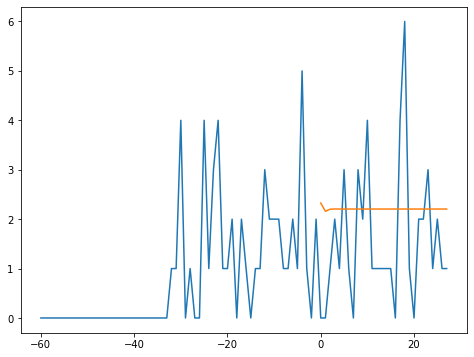

In [0]:
plt.plot(range(-60, 28), np.concatenate([val_x[2], val_y[2]], axis = 0))
plt.plot(range(0, 28), predict_result[2].numpy())